In [1]:
from IPython.display import Latex
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.misc
from scipy.stats import norm
import tqdm

dt = 1
Ns = 500 # number of particles
Nt = 12 # threshold number of particles

In [2]:
x_dim = 4
z_dim = 2

P0 = np.eye(x_dim) * 1e-1
x0 = np.zeros(x_dim)
x_start = x0 #+ np.random.multivariate_normal(np.zeros(4), P0)
lent = 100
R = np.eye(z_dim) * 1e-1
Q = np.eye(x_dim) * 1

In [4]:
zs, xs = [], []
for i in range(lent):
    z = [i] * z_dim #+ [np.random.randn(), np.random.randn()] @ R
    xs.append([i] * z_dim)
    zs.append(z)
measurements = np.array(zs) + x0[:z_dim]
trajectory = np.array(xs) + x0[:z_dim]

In [5]:
def f(x):
    xout = np.empty_like(x)
    xout[:z_dim] = x[:z_dim] + x[z_dim:x_dim] * dt # r = r + v * dt
    xout[z_dim:x_dim] = x[z_dim:x_dim] # v = v            
    return xout
    
def h(x):
    return x[:z_dim]

In [6]:
def resetWeights():    
    ws = np.ones((Ns, x_dim))*(1./Ns)
    logweights = np.log(ws)
    return ws, logweights
def resetParticles(x, P):
    particles_k = np.random.multivariate_normal(x, P, Ns)
    return particles_k
def resetNoise():
    noise_k = np.random.multivariate_normal(np.zeros(x_dim), Q, Ns)
    return noise_k
def propagateParticles(particles, noise):
    new_particles = np.zeros(particles.shape)
    for i in range(Ns):
        new_particles[i,:] = f(particles[i,:] + noise[i,:])
    return new_particles
def updateWeights(index, new_particles, logweights):
    measurement = measurements[index]
    for i in range(Ns):
        vi = (h(new_particles[i,:]) - measurement)
        logweights[i] = -0.5*vi.T@np.linalg.inv(R)@vi + logweights[i]
    maxlog = np.max(logweights)
    intermediate_weights = np.exp(logweights - maxlog)
    new_weights = intermediate_weights/(np.sum(intermediate_weights))
    return logweights, new_weights
def computeEstimate(weights, particles):
    x_new = np.zeros(x_dim)
    P_new = np.zeros((x_dim,x_dim))
    for i in range(Ns):
        x_new += weights[i]*particles[i,:]
    for i in range(Ns):
        diff = np.array([(particles[i,:] - x_new)])
        P_new += weights[i]* (diff.T @ diff)
    return x_new, P_new
def effectiveParticles(weights):
    return 1/(np.sum(weights*weights))

In [7]:
ws, logweights = resetWeights()
first_particles = resetParticles(x_start, P0)
noise = resetNoise()
#new_particles = propagateParticles(first_particles, noise)
#logweights, ws = updateWeights(1, new_particles, logweights)
#new_est, new_P = computeEstimate(ws, new_particles)
#alphas = ws/np.max(ws)

In [8]:
def runParticleFilter():
    P = P0
    x_start = x0 #+ numpy.random.multivariate_normal(numpy.zeros(4), P0)
    ws, logweights = resetWeights()
    particles_k = resetParticles(x_start, P)
    noise = resetNoise()
    Neff = Ns
    
    P_array = np.zeros((lent, x_dim, x_dim))
    x_array = np.zeros((lent, x_dim))
    P_array[0] = P
    x_array[0,:] = x_start
    for i in range(1, lent):
        new_particles = propagateParticles(particles_k, noise)
        logweights, ws = updateWeights(i, new_particles, logweights)
        x_new, P_new = computeEstimate(ws, new_particles)
        Neff = effectiveParticles(ws)
        
        P_array[i] = P_new
        x_array[i] = x_new
        
        if Neff < Nt:
            particles_k = resetParticles(x_new, P_new)
            noise = resetNoise()
            ws, logweights = resetWeights()
        else:
            particles_k = new_particles
            noise = resetNoise()
    return x_array, P_array
pfresults = runParticleFilter()
pf_traj, pf_cov = pfresults

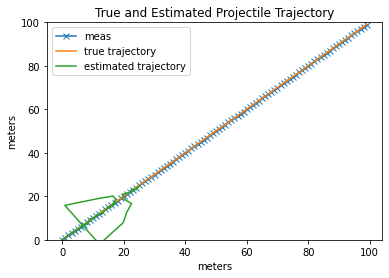

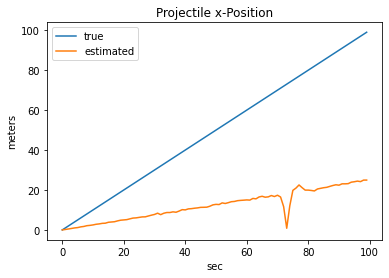

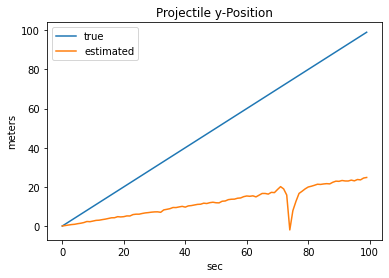

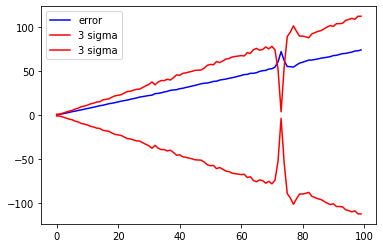

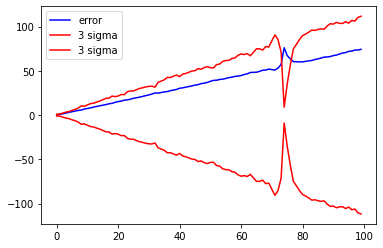

In [9]:
plt.plot(measurements[:,0], measurements[:,1], label='meas', marker = 'x')
plt.plot(trajectory[:,0], trajectory[:,1], label='true trajectory')
plt.plot(pf_traj[:,0], pf_traj[:,1], label='estimated trajectory')
plt.title('True and Estimated Projectile Trajectory')
plt.xlabel('meters'); plt.ylabel('meters')
plt.legend(loc='best')
plt.ylim([0,100])
plt.show()
plt.plot(trajectory[:,0], label='true')
plt.plot(pf_traj[:,0], label='estimated')
plt.legend(loc='best')
plt.title('Projectile x-Position')
plt.xlabel('sec'); plt.ylabel('meters')
plt.show()
plt.plot(trajectory[:,1], label='true')
plt.plot(pf_traj[:,1], label='estimated')
plt.legend(loc='best')
plt.title('Projectile y-Position')
plt.xlabel('sec'); plt.ylabel('meters')
plt.show()


x_err = trajectory[:,0] - pf_traj[:,0]
y_err = trajectory[:,1] - pf_traj[:,1]

xsig, ysig, xdotsig, ydotsig = [], [], [], []
for i in range(len(pf_cov)):
    xsig.extend([np.sqrt(pf_cov[i][0][0])])
    ysig.extend([np.sqrt(pf_cov[i][1][1])])
    xdotsig.extend([np.sqrt(pf_cov[i][2][2])])
    ydotsig.extend([np.sqrt(pf_cov[i][3][3])])
plt.plot(x_err, 'b-', label='error')
plt.plot(3*np.array(xsig), 'r-', label='3 sigma')
plt.plot(-3*np.array(xsig), 'r-', label='3 sigma')
plt.legend(loc='best')
plt.show()
plt.plot(y_err, 'b-', label='error')
plt.plot(3*np.array(ysig), 'r-', label='3 sigma')
plt.plot(-3*np.array(ysig), 'r-', label='3 sigma')
plt.legend(loc='best')
plt.show()